# Analysing simulation results: Domain wall pair conversion

## Simulation
### Problem description

We want to simulate a domain wall conversion in a two-dimensional thin film sample with:

- exchange energy constant $A = 15 \,\text{pJ}\,\text{m}^{-1}$,
- Dzyaloshinskii-Moriya energy constant $D = 3 \,\text{mJ}\,\text{m}^{-2}$,
- uniaxial anisotropy constant $K = 0.5 \,\text{MJ}\,\text{m}^{-3}$ with $\hat{\mathbf{u}} = (0, 0, 1)$ in the out of plane direction,
- gyrotropic ratio $\gamma = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$, and
- Gilbert damping $\alpha=0.3$.

Please carry out the following steps:

1. Create the following geometry with discretisation cell size $(2 \,\text{nm}, 2 \,\text{nm}, 2 \,\text{nm})$.
    
    <img src="figures/dw_pair_conversion_geometry.png" width="400">  

2. Initialise the magnetisation so that when relaxes, a domain pair is present in the narrower part of the geometry.

3. Relax the system. Is a domain wall pair contained in the constrained part?

4. Apply the spin polarised current in the positive $x$ direction with velocity $\mathbf{u} = (400, 0, 0) \,\text{m}\,\text{s}^{-1}$, with $\beta=0.5$.

5. Evolve the system over $0.2 \,\text{ns}$. What did you get? [1]

### References

[1] Zhou, Y., & Ezawa, M. (2014). A reversible conversion between a skyrmion and a domain-wall pair in a junction geometry. *Nature Communications* **5**, 8. https://doi.org/10.1038/ncomms5652


### Solution

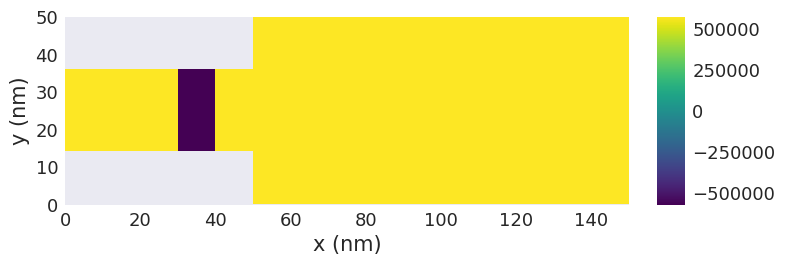

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

system = mm.System(name='dw_pair_conversion')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=2.211e5) + mm.Damping(alpha=alpha)

p1 = (0, 0, 0)
p2 = (150e-9, 50e-9, 2e-9)
cell = (2e-9, 2e-9, 2e-9)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

def Ms_fun(pos):
    x, y, z = pos
    if x < 50e-9 and (y < 15e-9 or y > 35e-9):
        return 0
    else:
        return Ms
    
def m_init(pos):
    x, y, z = pos
    if 30e-9 < x < 40e-9:
        return (0.1, 0.1, -1)
    else:
        return (0.1, 0.1, 1)
    
system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_fun, valid="norm")

system.m.z.sel('z').mpl.scalar()

Running OOMMF (ExeOOMMFRunner)[2024/06/09 21:19]... (0.4 s)


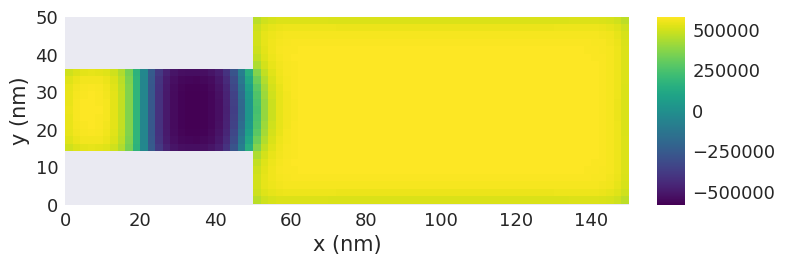

In [2]:
md = oc.MinDriver()
md.drive(system)

system.m.z.sel('z').mpl.scalar()

In [3]:
ux = 400  # velocity in x direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += mm.ZhangLi(u=ux, beta=beta)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/200 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/06/09 21:19] took 1.3 s


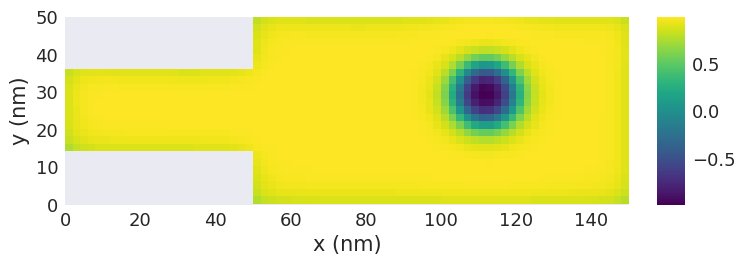

In [4]:
td = oc.TimeDriver()
td.drive(system, t=0.2e-9, n=200, verbose=2)

system.m.orientation.z.sel('z').mpl.scalar()

As a result, we got a skyrmion formed in the wider region.

## Data analysis

We can use the `micromagneticdata` package for post processing of simulation data.

We get access to:
- initial magnetisation
- magnetisation snapshots from the simulation, e.g. at the timesteps specified in `time_driver.drive(...)`
- tabular data recorded during the simulation via `ubermagtable`, e.g. total energy as a function of time

In [5]:
import micromagneticdata as mdata 

### `Data`

We can access data from past simulation runs based on the system name used to run the simulation.

In [6]:
data = mdata.Data('dw_pair_conversion')

The `Data` object contains all simulation runs of the `System`, these are called drives. We can check how many drives does our data has:

In [7]:
data.n

2

We have used two drivers in our simulation, which has created two corresponding drives.

We can also extract the details using the `info` property.

In [8]:
data.info

,drive_number,date,time,driver,adapter,n_threads,t,n
0,0,2024-06-09,21:19:45,MinDriver,oommfc,None,NaN,NaN
1,1,2024-06-09,21:19:45,TimeDriver,oommfc,None,2.000000e-10,200.0


### `Drive`
We can explicitly check the two drivers seperately by indexing the `Data` object.

In [9]:
data[0].info

{'drive_number': 0,
 'date': '2024-06-09',
 'time': '21:19:45',
 'driver': 'MinDriver',
 'adapter': 'oommfc',
 'n_threads': None}

A `drive` object gives acces to all data created from a single simulation run, e.g. call to `min_driver.drive()`

We can obtain the intial magnetisation with `m0`. We get a `discretisedfield.Field` and can use its plotting methods to visualise the initial configuration

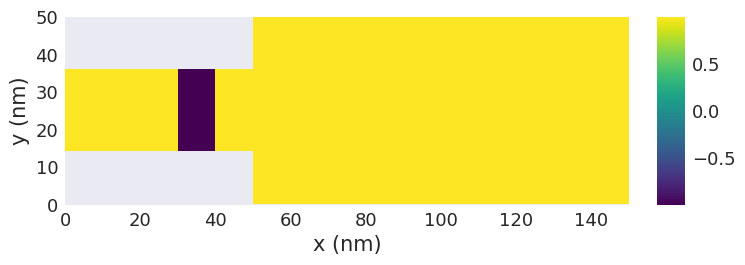

In [10]:
data[0].m0.orientation.sel('z').z.mpl.scalar()

We can check the number of simulation snapshots saved for the drive (the initial magnetisation `m0` is always excluded):

In [11]:
data[0].n

1

For the first drive, the energy minimisation, we only have one single element, saved at the end of the energy minimisation.

To obtain the finial state we can access the first data element of the drive.

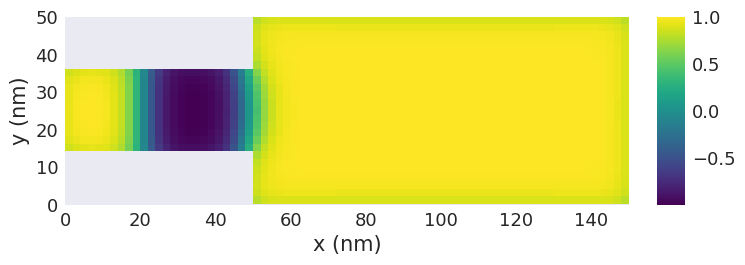

In [12]:
data[0][0].orientation.sel('z').z.mpl.scalar()

We can also use negative indices to access elements of the drive starting from the back.

In this case we only have a single element in the drive, so the first and the last element are identical:

In [13]:
data[0][0] == data[0][-1]

True

Let us now study the time drive (`data[1]`) in more detail. For convenience we assign it to a new name `time_drive` (and use negative indexing to select the last drive).

In [14]:
time_drive = data[-1]
time_drive.info

{'drive_number': 1,
 'date': '2024-06-09',
 'time': '21:19:45',
 'driver': 'TimeDriver',
 'adapter': 'oommfc',
 't': 2e-10,
 'n': 200,
 'n_threads': None}

We can observe the final magnetisation state of the time driver by indexing the last drive, i.e., `time_drive[-1]`

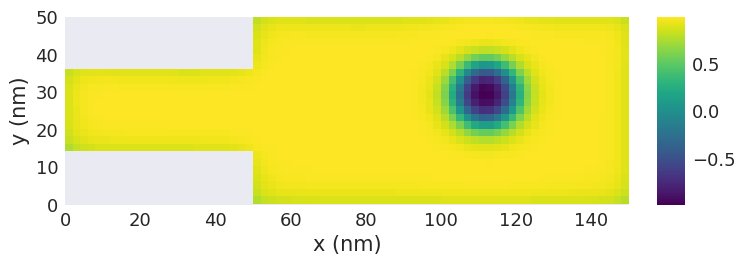

In [15]:
time_drive[-1].orientation.sel('z').z.mpl.scalar()

We can create an interactive plot with a slider for the time to interactively investigate the conversion of the domain wall pair into a skyrmion.

In [16]:
time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### `Table`

We also get access to all tabular data recorded during the drive. The data is made available as `pandas.Dataframe`.

In [17]:
time_drive.table.data

,E,E_calc_count,max_dmdt,dE/dt,delta_E,average_u,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,DMI_Cnv_z:dmi:Energy,E_uniaxialanisotropy,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-3.138757e-19,61.0,5105.786662,1.131548e-09,1.234439e-22,400.0,7.819720e-19,24.981919,24.981919,24.981919,-1.791404e-18,6.955566e-19,8.0,8.0,0.0,-0.004356,0.001711,0.779309,1.146802e-13,1.000000e-12
1,-3.123365e-19,92.0,5393.820356,1.881778e-09,2.714936e-22,400.0,7.859070e-19,25.999114,25.999114,25.999114,-1.795166e-18,6.969222e-19,14.0,5.0,1.0,-0.007399,0.002527,0.779212,1.481817e-13,2.000000e-12
2,-3.101629e-19,129.0,5478.105937,2.410525e-09,1.525909e-22,400.0,7.908188e-19,26.839540,26.839540,26.839540,-1.800156e-18,6.991741e-19,21.0,6.0,2.0,-0.010058,0.002596,0.779103,6.371456e-14,3.000000e-12
3,-3.075651e-19,172.0,5775.596117,2.750961e-09,2.026333e-22,400.0,7.963184e-19,27.523018,27.523018,27.523018,-1.806035e-18,7.021517e-19,28.0,6.0,3.0,-0.012243,0.002078,0.779037,7.397143e-14,4.000000e-12
4,-3.046980e-19,209.0,6099.408455,2.938665e-09,1.417659e-22,400.0,8.020796e-19,27.968494,27.968494,27.968494,-1.812650e-18,7.058726e-19,35.0,6.0,4.0,-0.013915,0.001139,0.779058,4.838847e-14,5.000000e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-4.666219e-20,7786.0,6419.713717,2.798949e-10,1.373560e-23,400.0,1.222876e-18,29.279242,29.396487,33.740702,-1.937412e-18,6.678731e-19,1372.0,6.0,195.0,-0.007893,-0.008017,0.899229,5.094469e-14,1.960000e-10
196,-4.634379e-20,7829.0,6444.188876,2.763562e-10,1.564748e-23,400.0,1.222846e-18,29.358338,29.358338,33.740702,-1.936677e-18,6.674871e-19,1379.0,6.0,196.0,-0.007885,-0.008007,0.899298,6.044352e-14,1.970000e-10
197,-4.601751e-20,7866.0,6397.295745,2.905618e-10,1.926693e-23,400.0,1.222790e-18,29.418283,29.418283,33.740702,-1.935846e-18,6.670387e-19,1386.0,6.0,197.0,-0.007876,-0.007998,0.899383,7.101084e-14,1.980000e-10
198,-4.568193e-20,7909.0,6374.587944,3.124776e-10,1.795553e-23,400.0,1.222710e-18,29.397007,29.419861,33.740702,-1.934920e-18,6.665281e-19,1393.0,6.0,198.0,-0.007866,-0.007989,0.899482,5.961504e-14,1.990000e-10


The `table` object provides a convenient plotting method. We can use it to visualise e.g. the total energy or the average magnetisation as a function of time. Ubermag, more precisely, `ubermagtable` automatically uses time for the x axis based on the metadata of the drive.

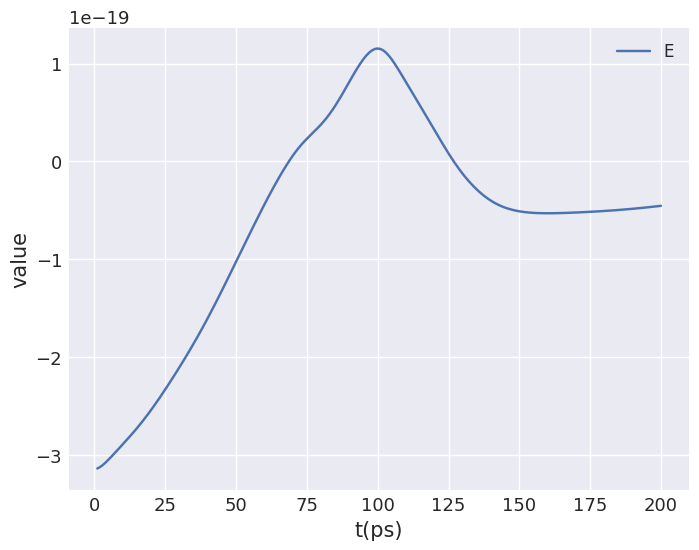

In [18]:
time_drive.table.mpl(y=['E'])

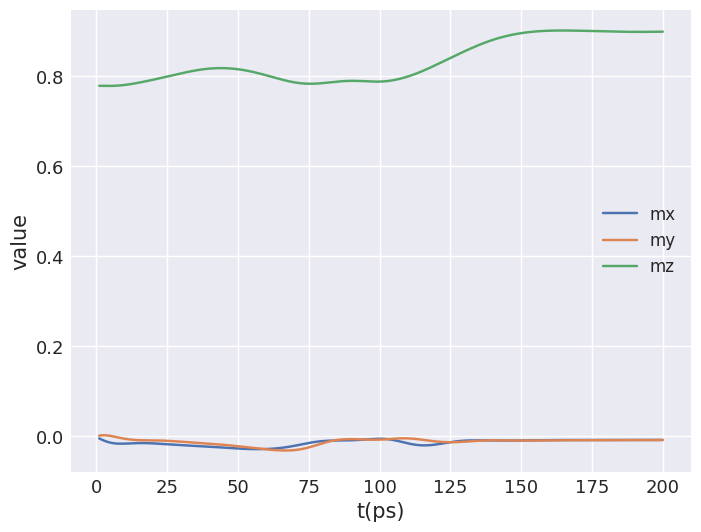

In [19]:
time_drive.table.mpl(y=['mx', 'my', 'mz'])

### Derived quantities using callbacks

We can also compute derived quantities for each time step and visualise them. As an example, we compute the topological charge density. Discretisedfield provides a function for this in `discretisedfield.tools`.

First, we compute the topolgical charge density for the final magnetisation state and plot it.

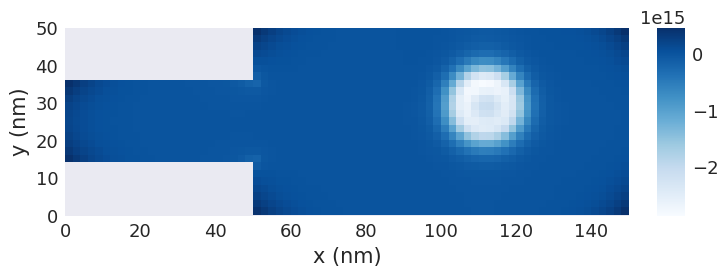

In [20]:
final_magnetisation = time_drive[-1]
top_charge_last_step = df.tools.topological_charge_density(final_magnetisation.sel('z'))

top_charge_last_step.mpl.scalar(cmap='Blues')

To compute a function for each time step, we use the `register_callback` method of `Drive`. We can pass in a function that will be called for each element of the drive. The function is only evaluated once we access an element of the drive. The `register_callback` method returns a new `Drive` object so that we still have access to the original data if required.

In this example we write a callback function that gets one magnetisation `m` and then selects a 2D slice normal to the `z` direction and computes the topological charge density.

In [21]:
def top_charge_plane(m):
    return df.tools.topological_charge_density(m.sel('z'))

top_charge = time_drive.register_callback(top_charge_plane)

We can now plot the data of the new `top_charge` drive object. We manually compute suitable colour limits based on the topological charge in the final state to avoid changes of the colour range when moving the slider. (The plotting function always has only access to the current frame and would re-compute a suitable but changing colour range for each frame, which makes it difficult to judge the changes in topological charge.)

In [22]:
c_min = top_charge_last_step.array.min()
c_max = top_charge_last_step.array.max()

top_charge.hv.scalar(kdims=['x', 'y'], clim=(c_min, c_max))

:DynamicMap   [t]
   :Image   [x,y]   (field)

### Conversion to `xarray.DataArray`

The drive object also provides a method to convert all magnetisation data into a single `DataArray` suitable for further post-processing outside Ubermag.

In [23]:
time_drive.to_xarray()

<xarray.DataArray 'field' (t: 200, x: 75, y: 25, z: 1, vdims: 3)>
array([[[[[     -0.        ,      -0.        ,       0.        ]],

         [[     -0.        ,      -0.        ,      -0.        ]],

         [[     -0.        ,      -0.        ,      -0.        ]],

         ...,

         [[     -0.        ,       0.        ,       0.        ]],

         [[      0.        ,       0.        ,       0.        ]],

         [[     -0.        ,       0.        ,       0.        ]]],


        [[[      0.        ,      -0.        ,      -0.        ]],

         [[      0.        ,      -0.        ,       0.        ]],

         [[     -0.        ,       0.        ,      -0.        ]],
...
         [[ 153709.90366831,   90849.4896136 ,  551832.97812946]],

         [[ 153335.36568133,  143941.16461874,  540526.78634789]],

         [[ 154519.39825465,  217376.75131842,  515044.75878245]]],


        [[[ 226300.61182204, -278646.99318387,  455569.84785932]],

         [[ 226637.6638938 , -208736.80814293,  491390.18532228]],

         [[ 228536.19152054, -155488.55738028,  509896.5754828 ]],

         ...,

         [[ 227688.03582733,   89413.40180091,  525892.95671219]],

         [[ 226284.55415879,  142651.47198073,  514631.76941469]],

         [[ 226432.93136019,  214961.84186743,  488793.9587767 ]]]]])
Coordinates:
  * x        (x) float64 1e-09 3e-09 5e-09 7e-09 ... 1.45e-07 1.47e-07 1.49e-07
  * y        (y) float64 1e-09 3e-09 5e-09 7e-09 ... 4.5e-08 4.7e-08 4.9e-08
  * z        (z) float64 1e-09
  * vdims    (vdims) <U1 'x' 'y' 'z'
  * t        (t) float64 1e-12 2e-12 3e-12 4e-12 ... 1.98e-10 1.99e-10 2e-10
Attributes:
    drive_number:  1
    date:          2024-06-09
    time:          21:19:45
    driver:        TimeDriver
    adapter:       oommfc
    t:             2e-10
    n:             200
    n_threads:     None